In [1]:
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNetV2
import tensorflow.keras.layers as layers
import tensorflow as tf
import numpy as np
import os

In [2]:
block1 = tf.keras.Sequential([tf.keras.layers.Conv2D(512, 1, padding='same'),
                     tf.keras.layers.BatchNormalization(),
                     tf.keras.layers.ReLU(),

                     tf.keras.layers.DepthwiseConv2D(3, strides=(2,2), padding='same'),
                     tf.keras.layers.BatchNormalization(),
                     tf.keras.layers.ReLU(),

                     tf.keras.layers.Conv2D(512, 1, padding='same'),
                     tf.keras.layers.BatchNormalization(),
                     tf.keras.layers.ReLU()])
                    # **** conv => depthwise-conv => conv ****
                    #output1 [BN,6,6,512]

block2 = tf.keras.Sequential([tf.keras.layers.Conv2D(512, 1, padding='same'),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.ReLU(),

                    tf.keras.layers.DepthwiseConv2D(3, strides=(2,2), padding='same'),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.ReLU(),

                    tf.keras.layers.Conv2D(512, 1, padding='same'),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.ReLU(),])
                    # **** conv => depthwise-conv => conv ****
                    #output1 [BN,3,3,512]
        
block3 = tf.keras.Sequential([tf.keras.layers.Conv2D(512, 1, padding='same'),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.ReLU(),

                    tf.keras.layers.DepthwiseConv2D(3),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.ReLU(),

                    tf.keras.layers.Conv2D(512, 1, padding='same'),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.ReLU()])
                    # **** conv => depthwise-conv => conv ****
                    #output1 [BN,1,1,512]

In [3]:
mobilenet_v2 = MobileNetV2(input_shape=(160,160,3), weights="imagenet", include_top=False)

9412608/9406464 [==============================] - 0s 0us/step


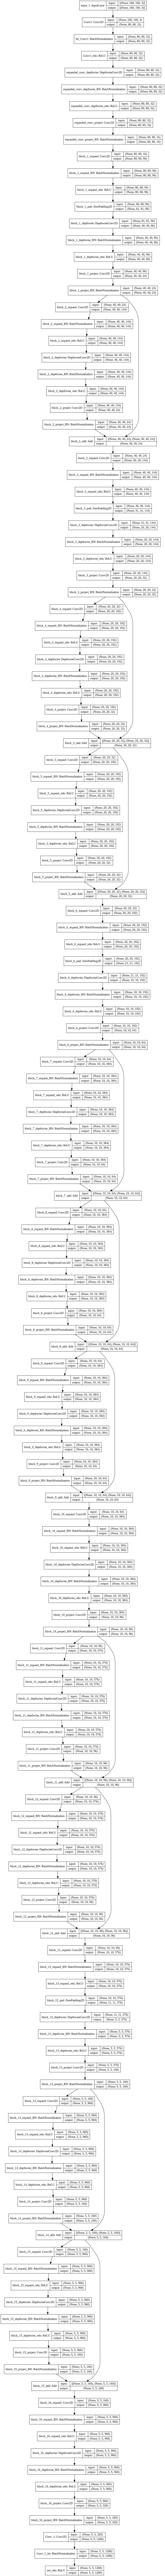

In [4]:
tf.keras.utils.plot_model(mobilenet_v2, show_shapes=True, expand_nested=True)

# Build feature extractor

In [5]:
mobilenet_v2 = MobileNetV2(input_shape=(160,160,3), weights="imagenet", include_top=False)
# feature extractor
fmap10x10 = mobilenet_v2.get_layer("block_13_expand_relu")
feature_extractor = tf.keras.Model(inputs=[mobilenet_v2.input], outputs=[fmap10x10.output])



# Build extra convolutional layers

In [6]:
input_layer = tf.keras.Input(shape=(160,160,3))
x = feature_extractor(input_layer)
y1 = block1(x)
y2 = block2(y1)
y3 = block3(y2)

In [7]:
print(x.shape)
print(y1.shape)
print(y2.shape)
print(y3.shape)

(None, 10, 10, 576)
(None, 5, 5, 512)
(None, 3, 3, 512)
(None, 1, 1, 512)


In [8]:
num_classes = 3

In [9]:
#conf header
confs = []
conf = layers.Conv2D(4 * num_classes, kernel_size=3, padding='same')(x)  # 4 * num_classes => anchor_box * num_classes
conf = tf.reshape(conf, [-1, 10*10*4,num_classes])
confs.append(conf)
conf = layers.Conv2D(6 * num_classes, kernel_size=3, padding='same')(y1)  # 6 * num_classes => anchor_box * num_classes
conf = tf.reshape(conf, [-1, 5*5*6,num_classes])
confs.append(conf)
conf = layers.Conv2D(6 * num_classes, kernel_size=3, padding='same')(y2)  # 6 * num_classes => anchor_box * num_classes
conf = tf.reshape(conf, [-1, 3*3*6,num_classes])
confs.append(conf)
conf = layers.Conv2D(4 * num_classes, kernel_size=1)(y3)   # 4 * num_classes => anchor_box * num_classes
conf = tf.reshape(conf, [-1, 1*1*4,num_classes])
confs.append(conf)


#location header
locs = []
loc = layers.Conv2D(4 * 4, kernel_size=3, padding='same')(x)     # 4 * 4 => anchor_box * (x,y,h,w)
loc = tf.reshape(loc, [-1, 10*10*4,4])
locs.append(loc)
loc = layers.Conv2D(6 * 4, kernel_size=3, padding='same')(y1)    # 6 * 4 => anchor_box * (x,y,h,w)
loc = tf.reshape(loc, [-1, 5*5*6,4])
locs.append(loc)
loc = layers.Conv2D(6 * 4, kernel_size=3, padding='same')(y2)    # 6 * 4 => anchor_box * (x,y,h,w)
loc = tf.reshape(loc, [-1, 3*3*6,4])
locs.append(loc)
loc = layers.Conv2D(4 * 4, kernel_size=1)(y3)       # 4 * 4 => anchor_box * (x,y,h,w)
loc = tf.reshape(loc, [-1, 1*1*4,4])
locs.append(loc)

confs = tf.concat(confs, axis=-2)
locs = tf.concat(locs, axis=-2)

In [10]:
mobilenet_ssd = tf.keras.Model(inputs=[input_layer], outputs=[confs,locs])

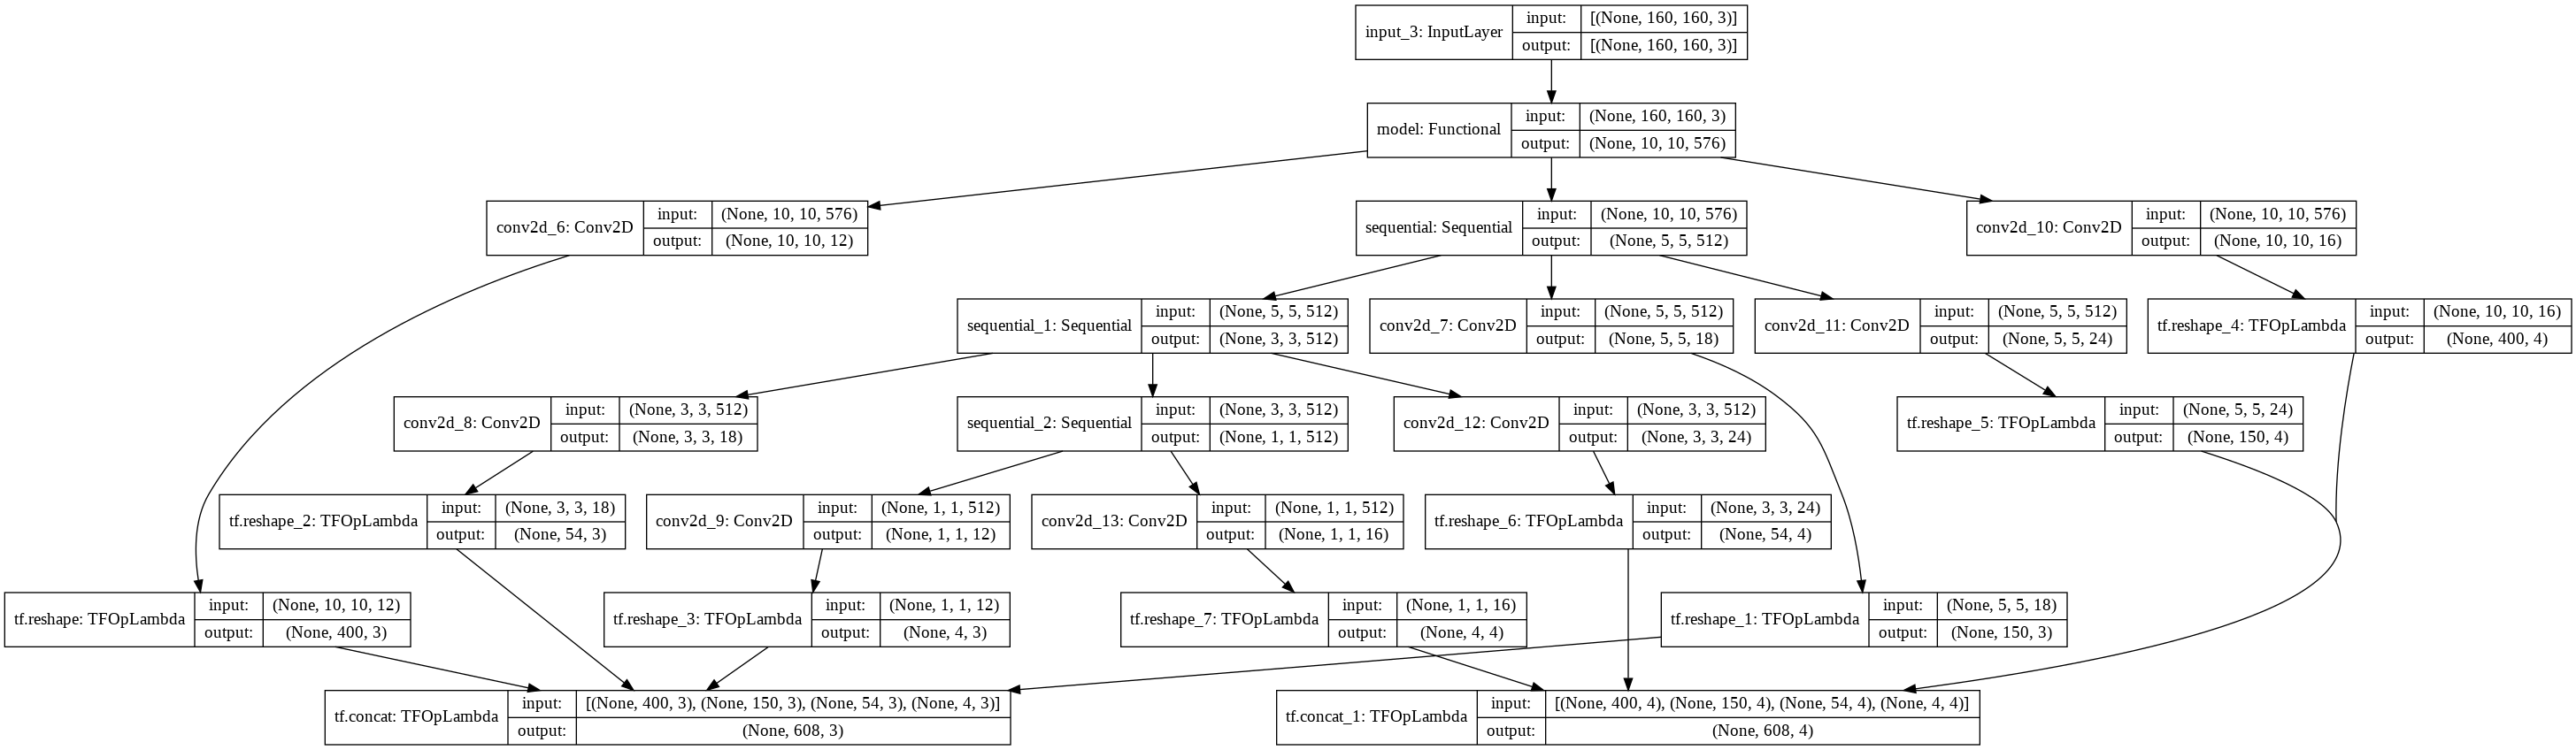

In [11]:
tf.keras.utils.plot_model(mobilenet_ssd, show_shapes=True, expand_nested=False)

In [12]:
mobilenet_ssd.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 10, 10, 576)  616256      input_3[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 5, 5, 512)    569344      model[0][0]                      
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 3, 3, 512)    536576      sequential[0][0]                 
____________________________________________________________________________________________

In [13]:
mobilenet_ssd(np.ones([1, 160,160,3]))

[<tf.Tensor: shape=(1, 608, 3), dtype=float32, numpy=
 array([[[ 4.2763051e-01, -1.0020771e+00,  2.3898932e-01],
         [-6.6635376e-01,  1.3269912e+00,  1.7074770e+00],
         [-1.1482567e+00,  9.3586689e-01,  3.0265634e+00],
         ...,
         [-1.2291039e-06, -7.9038082e-06, -1.6745270e-06],
         [-2.5377908e-06, -4.2285251e-06,  2.4830713e-06],
         [-5.0659200e-06, -3.2919195e-07,  8.1101216e-06]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 608, 4), dtype=float32, numpy=
 array([[[ 4.7655015e+00,  9.8231250e-01, -3.2381368e-01, -8.4651774e-01],
         [ 7.6013285e-01, -1.2384547e+00,  2.6398075e-01,  2.0218787e+00],
         [ 2.9980550e+00,  8.1946313e-01,  3.0022889e-01,  6.2719154e-01],
         ...,
         [-6.5478498e-06,  5.4072480e-06, -1.2983901e-06,  8.7649987e-06],
         [ 2.3218915e-06, -3.6683323e-06, -4.2778615e-06,  4.6866044e-06],
         [-2.7418416e-06,  2.3948153e-06, -9.9923973e-06,  4.9860364e-06]]],
       dtype=float32)>]

In [ ]:
# 예측 shape : 1,608, 3  --> 608 anchor_box, 3 class , 즉 608 anchor_box에 대해 클래스별 확률 예측

In [14]:
mobilenet_ssd.save("ssd160-mobilenet.h5")